## Encoders（エンコーダー）

HTM入力用のSDRに異なる型を符号化するためのクラス。

汎用性の高いと思われる以下の4種類は別途クラスが用意されています。

- Scalar（スカラーエンコーダー）
- Date/time（日付エンコーダー）
- Category（カテゴリーエンコーダー）
- Multi（マルチエンコーダー）

In [209]:
import numpy

### ScalarEncoder（スカラーエンコーダー）

スカラーエンコーダは、数値（浮動小数点）をビットの配列にエンコードします。出力は 1 の連続するブロックを除いて 0 です。この連続するブロックの位置は、入力値によって連続的に変化します。

エンコーディングは線形です。非線形エンコーディングをしたい場合は、エンコーディングの前にスカラを（対数関数を適用するなどして）変換してください

In [210]:
from htm.bindings.encoders import ScalarEncoder, ScalarEncoderParameters
from htm.bindings.sdr import SDR, Metrics

**パラメータ**
- `activeBits`: (int) 出力のビット数．
- `size`: (int)  1つの値をエンコードするために設定されるビット数 - 出力信号の "幅 "制限：センタリングの問題を避けるため，`size`は奇数でなければいけません
- `minimum`: (float) 入力信号の最小値．
- `maximum`: (float) 入力信号の上限値．(periodic == True の場合，入力は厳密にはより小さい値になります)
- `clipInput`: `true` の場合，`minmum`, `maxmum`の範囲外の値をエンコードしません

In [211]:
scalarEncoderParams = ScalarEncoderParameters()
scalarEncoderParams.minimum = 2.5
scalarEncoderParams.maximum = 97.5
scalarEncoderParams.activeBits = 3
scalarEncoderParams.size = 21
scalarEncoderParams.clipInput  = True

enc = ScalarEncoder(scalarEncoderParams)

print ("3 =", enc.encode(3))
print ("4 =", enc.encode(4))
print ("5 =", enc.encode(5))

3 = SDR( 21 ) 0, 1, 2
4 = SDR( 21 ) 0, 1, 2
5 = SDR( 21 ) 0, 1, 2


In [212]:
print ("3 =", enc.encode(3).dense)
print ("4 =", enc.encode(4).dense)
print ("5 =", enc.encode(5).dense)

3 = [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4 = [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5 = [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


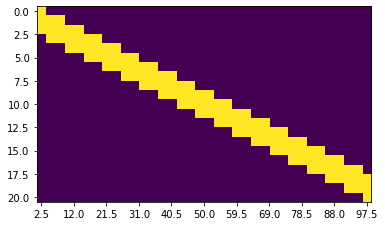

In [217]:
n_samples = (enc.parameters.maximum - enc.parameters.minimum) / enc.parameters.resolution
oversample = 2 # Use more samples than needed to avoid aliasing & artifacts.
n_samples  = int(round( oversample * n_samples ))

sdrs = []
for i in np.linspace(enc.parameters.minimum, enc.parameters.maximum, n_samples):
  sdrs.append( enc.encode( i ) )

import matplotlib.pyplot as plt
%matplotlib inline

rf = np.zeros([ enc.size, len(sdrs) ], dtype=np.uint8)
for i in range(len(sdrs)):
  rf[ :, i ] = sdrs[i].dense
plt.imshow(rf, interpolation='nearest')
plt.title( "ScalarEncoder Receptive Fields")
plt.ylabel("Cell Number")
plt.xlabel("Input Value")
n_ticks = 11
plt.xticks( np.linspace(0, len(sdrs)-1, n_ticks),
          np.linspace(enc.parameters.minimum, enc.parameters.maximum, n_ticks))
plt.show()

In [148]:
# maxmumをエンコードします。
print ("100  =", enc.encode(100))

# より大きな数値が同じエンコーディングを取得することを確認してください。
print ("1000 =", enc.encode(1000))

100  = SDR( 23 ) 20, 21, 22
1000 = SDR( 23 ) 20, 21, 22


### RandomDistributedScalarEncoder（ランダム分散スカラーエンコーダー）

このクラスは，スカラ値を空間プーラーへのスカラ入力に適したランダム分布表現にマップします．

In [204]:
from htm.bindings.encoders import RDSE, RDSE_Parameters
from htm.bindings.sdr import SDR, Metrics

**パラメータ**
- `size`: (int) 表現のビット数（`> activeBits` でなければならない）。範囲が大きくなっても新しい表現を選択できるように、`size` は十分に大きくなければならない。`activeBits = 21` の場合、`size = 400` の値が典型的です．
- `activeBits`: (int) 空間プーラー列が十分に大きくオーバーラップして偽一致を避けるために十分に大きくなければならない。一般的には `activeBits = 21` の値が用いられる
- `resolution`: (float) 出力表現の解像度を表す浮動小数点型の正の数値．

In [205]:
RDSE_Parameters = RDSE_Parameters()
RDSE_Parameters.activeBits = 3
RDSE_Parameters.resolution = 5
RDSE_Parameters.size       = 23

enc = RDSE( RDSE_Parameters )

print ("3 =   ", enc.encode(3))
print ("4 =   ", enc.encode(4))
print ("5 =   ", enc.encode(5))
print ("---")
print ("100 = ", enc.encode(100))
print ("1000 =", enc.encode(1000))

3 =    SDR( 23 ) 9, 20
4 =    SDR( 23 ) 9, 20
5 =    SDR( 23 ) 16, 20
---
100 =  SDR( 23 ) 4, 16, 20
1000 = SDR( 23 ) 0, 10, 19


In [206]:
print ("3 =   ", enc.encode(3).dense)
print ("4 =   ", enc.encode(4).dense)
print ("5 =   ", enc.encode(5).dense)
print ("---")
print ("100 = ", enc.encode(100).dense)
print ("1000 =", enc.encode(1000).dense)

3 =    [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
4 =    [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
5 =    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
---
100 =  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
1000 = [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0]


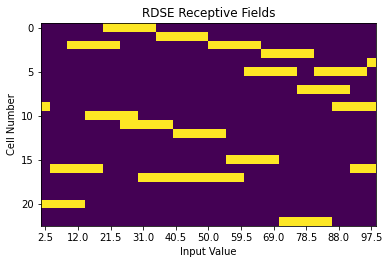

In [207]:
args_maximum =97.5
args_minimum=2.5

n_samples = (args_maximum - args_minimum) / enc.parameters.resolution
oversample = 2 # Use more samples than needed to avoid aliasing & artifacts.
n_samples  = int(round( oversample * n_samples ))

sdrs = []
for i in numpy.linspace(args_minimum, args_maximum, n_samples):
  sdrs.append( enc.encode( i ) )

import matplotlib.pyplot as plt
%matplotlib inline

rf = np.zeros([ enc.size, len(sdrs) ], dtype=np.uint8)
for i in range(len(sdrs)):
  rf[ :, i ] = sdrs[i].dense
plt.imshow(rf, interpolation='nearest')
plt.title( "RDSE Receptive Fields")
plt.ylabel("Cell Number")
plt.xlabel("Input Value")
n_ticks = 11
plt.xticks( np.linspace(0, len(sdrs)-1, n_ticks),
          np.linspace(args_minimum, args_maximum, n_ticks))
plt.show()

### DateEncoder（日付エンコーダ）

日付エンコーダは、コンストラクタで指定したエンコーディングパラメータに従って日付をエンコードします。

日付エンコーダへの入力は `datetime.datetime` オブジェクトです。

出力は、複数のサブエンコーディングを連結したもので、それぞれが日付の異なる側面をエンコードします。

In [75]:
import datetime
from htm.encoders.date import DateEncoder

**パラメータ**
- `season`: (int | tuple) 一年の季節。
    - (int) 属性の幅; デフォルトの半径 = 91.5日 (1シーズン)
    - (tuple) `season[0] = width;`  `season[1] = radius`

- `dayOfWeek`: (int | tuple) Day of week, where monday = 0, units = 1 day.タイムスタンプはday:noonと比較されるので、エンコーディングは真夜中に表現を切り替えます.
    - (int) width of attribute; default radius = 1 day
    - (tuple) dayOfWeek[0] = width; dayOfWeek[1] = radius

- `weekend`: (int) 週末かどうか。注意:実装では "weekend "は金曜日の午後6時から日曜日の午前0時までと扱う。
    - (int) 属性の幅
    - TODO remove and replace by customDays=(width, ["Saturday", "Sunday"]) ?

- `holiday`: (int)休日かどうか, boolean: 0, 1
    - (int) 属性の幅

- `timeOfday`: (int | tuple) 一日の時間, where midnight = 0, units = hour.
    - (int) 属性の幅: default radius = 4 hours
    - (tuple) timeOfDay[0] = width; timeOfDay[1] = radius
    
- `customDays`: (tuple)特定の曜日をカスタムエンコードする方法です.
    - [0] (int) 属性の幅
    - [1] (str | list) "Monday" や "mon" のような曜日を表す文字列、またはこれらの文字列のリスト.


In [76]:
dateEncoder = DateEncoder(season  = 5) 

now = datetime.datetime.strptime("2014-05-02 13:08:58", "%Y-%m-%d %H:%M:%S")
print ("now =       ", dateEncoder.encode(now))

nextMonth = datetime.datetime.strptime("2014-06-02 13:08:58", "%Y-%m-%d %H:%M:%S")
print ("next month =", dateEncoder.encode(nextMonth))

xmas = datetime.datetime.strptime("2014-12-25 13:08:58", "%Y-%m-%d %H:%M:%S")
print ("xmas =      ", dateEncoder.encode(xmas))

now =        SDR( 20 ) 7, 8, 9, 10, 11
next month = SDR( 20 ) 8, 9, 10, 11, 12
xmas =       SDR( 20 ) 0, 1, 2, 3, 4


In [91]:
dateEncoder = DateEncoder(dayOfWeek  = 5, weekend=2, timeOfDay=4) 

now = datetime.datetime.strptime("2014-05-02 13:08:58", "%Y-%m-%d %H:%M:%S")
print ("now =       ", dateEncoder.encode(now))

nextMonth = datetime.datetime.strptime("2014-06-02 13:08:58", "%Y-%m-%d %H:%M:%S")
print ("next month =", dateEncoder.encode(nextMonth))

xmas = datetime.datetime.strptime("2014-12-25 13:08:58", "%Y-%m-%d %H:%M:%S")
print ("xmas =      ", dateEncoder.encode(xmas))

now =        SDR( 63 ) 20, 21, 22, 23, 24, 35, 36, 52, 53, 54, 55
next month = SDR( 63 ) 0, 1, 2, 3, 4, 35, 36, 52, 53, 54, 55
xmas =       SDR( 63 ) 15, 16, 17, 18, 19, 35, 36, 52, 53, 54, 55


In [92]:
print ("now =       ", dateEncoder.encode(now).dense)
print ("next month =", dateEncoder.encode(nextMonth).dense)
print ("xmas =      ", dateEncoder.encode(xmas).dense)

now =        [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0]
next month = [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0]
xmas =       [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0]


### CategoryEncoders（カテゴリエンコーダー）

(文字列で記述された）離散的なカテゴリのリストをエンコードします。

ゼロの値は "unknown category "のために予約されています。

内部的には半径1のScalarEncoderを使用していますが、整数のみをエンコードしているため、混合出力は得られません。

SDRCategoryEncoder は、別の方法でカテゴリをエンコードします。

In [221]:
from htm.bindings.encoders import ScalarEncoder, ScalarEncoderParameters
from htm.bindings.sdr import SDR, Metrics

**パラメータ**
- ```category``` – 離散的な文字列カテゴリのリスト

In [222]:
categories = ("unknown","cat", "dog", "monkey", "slow loris")

scalarEncoderParams = ScalarEncoderParameters()
scalarEncoderParams.minimum = 1
scalarEncoderParams.maximum = 5
scalarEncoderParams.activeBits = 3
scalarEncoderParams.category = True

enc = ScalarEncoder(scalarEncoderParams)

cat = enc.encode(categories.index("cat")+1)
dog = enc.encode(categories.index("dog")+1)
monkey = enc.encode(categories.index("monkey")+1)
loris = enc.encode(categories.index("slow loris")+1)

print ("cat =       ", cat)
print ("dog =       ", dog)
print ("monkey =    ", monkey)
print ("slow loris =", loris)

cat =        SDR( 15 ) 3, 4, 5
dog =        SDR( 15 ) 6, 7, 8
monkey =     SDR( 15 ) 9, 10, 11
slow loris = SDR( 15 ) 12, 13, 14


In [223]:
print ("cat =       ", cat.dense)
print ("dog =       ", dog.dense)
print ("monkey =    ", monkey.dense)
print ("slow loris =", loris.dense)

cat =        [0 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
dog =        [0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
monkey =     [0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
slow loris = [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]


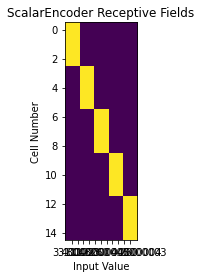

In [227]:
n_samples = int(enc.parameters.maximum - enc.parameters.minimum + 1)

sdrs = []
for i in np.linspace(enc.parameters.minimum, enc.parameters.maximum, n_samples):
  sdrs.append( enc.encode( i ) )

import matplotlib.pyplot as plt
%matplotlib inline

rf = np.zeros([ enc.size, len(sdrs) ], dtype=np.uint8)
for i in range(len(sdrs)):
  rf[ :, i ] = sdrs[i].dense
plt.imshow(rf, interpolation='nearest')
plt.title( "ScalarEncoder Receptive Fields")
plt.ylabel("Cell Number")
plt.xlabel("Input Value")
n_ticks = 11
plt.xticks( np.linspace(0, len(sdrs)-1, n_ticks),
          np.linspace(enc.parameters.minimum, enc.parameters.maximum, n_ticks))
plt.show()

In [11]:
print (enc.encode(1+2))

SDR( 15 ) 6, 7, 8


In [12]:
print (enc.encode(categories.index("unknown")+1))

SDR( 15 ) 0, 1, 2


In [13]:
print (enc.decode(categories.index("cat")+1))

AttributeError: 'htm.bindings.encoders.ScalarEncoder' object has no attribute 'decode'

In [14]:
catdog = numpy.array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0])
print (enc.decode(catdog))

NameError: name 'numpy' is not defined

In [230]:
from htm.bindings.sdr import SDR
inputSDR  = SDR( dimensions = (8, 8) )
inputSDR.randomize( .02 )
print(inputSDR)
print(inputSDR.dense)

SDR( 8, 8 ) 44
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [229]:
from htm.bindings.encoders import ScalarEncoder, ScalarEncoderParameters
scalarEncoderParams = ScalarEncoderParameters()
scalarEncoderParams.minimum = 2.5
scalarEncoderParams.maximum = 97.5
scalarEncoderParams.activeBits = 3
scalarEncoderParams.size = 21
scalarEncoderParams.clipInput  = True

enc = ScalarEncoder(scalarEncoderParams)

print ("3 =", enc.encode(3))
print ("4 =", enc.encode(4))
print ("5 =", enc.encode(5))

3 = SDR( 21 ) 0, 1, 2
4 = SDR( 21 ) 0, 1, 2
5 = SDR( 21 ) 0, 1, 2
